In [2]:
import torch

def _pchip_slopes(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """
    Calculates the PCHIP slopes for a batch of 1D functions.
    Matches the logic of scipy.interpolate.PchipInterpolator.
    
    Args:
        x: The x-coordinates of the knots. Shape (B, n)
        y: The y-coordinates of the knots. Shape (B, n)
        
    Returns:
        torch.Tensor: The slopes at each knot. Shape (B, n)
    """
    # Ensure all tensors are on the same device and dtype
    x = x.to(y.device, y.dtype)
    
    # 1. Calculate finite differences (secant slopes)
    # h = x[..., 1:] - x[..., :-1]
    # delta = (y[..., 1:] - y[..., :-1]) / h
    
    # Need to handle non-finite values that can arise
    # from identical x-values.
    # We'll use where to avoid division by zero.
    h = x[..., 1:] - x[..., :-1]
    delta = (y[..., 1:] - y[..., :-1]) / h
    
    # Replace NaNs (from 0/0) with 0
    delta = torch.where(torch.isnan(delta), torch.zeros_like(delta), delta)
    
    # Replace Infs (from y/0) with a large number
    # (or handle as needed; 0 is a safe choice for slopes
    # if x-values are identical)
    delta = torch.where(torch.isinf(delta), 0.0, delta)

    # Initialize slopes tensor
    m = torch.zeros_like(x)

    # 2. Interior points
    # PCHIP logic: if delta[i-1] and delta[i] have different signs,
    # or if either is zero, set m[i] = 0.
    # If they have the same sign, use a weighted harmonic mean.
    
    # Create masks for where signs agree (and neither is zero)
    mask = (delta[..., :-1] * delta[..., 1:]) > 0
    
    # Get relevant h and delta slices for interior points
    h_left = h[..., :-1]
    h_right = h[..., 1:]
    delta_left = delta[..., :-1]
    delta_right = delta[..., 1:]

    # Weighted harmonic mean formula
    h_s = h_left + h_right
    w1 = (h_left + h_s) / h_s
    w2 = (h_right + h_s) / h_s
    
    # m_i = 1.0 / (w1 / delta[i-1] + w2 / delta[i])
    # Protect against division by zero if delta_left or delta_right is 0
    # (though mask should already handle this)
    denom = w1 / delta_left + w2 / delta_right
    m_interior = 1.0 / denom
    
    # Set interior slopes
    m[..., 1:-1] = torch.where(mask, m_interior, 0.0)

    # 3. Endpoints (using one-sided 3-point formula with monotonicity clamps)
    
    # Left endpoint
    h0, h1 = h[..., 0], h[..., 1]
    d0, d1 = delta[..., 0], delta[..., 1]
    hs = h0 + h1
    
    # One-sided 3-point formula
    m0 = ((2*h0 + h1)*d0 - h0*d1) / hs
    
    # Monotonicity clamps
    s_m0 = torch.sign(m0)
    s_d0 = torch.sign(d0)
    s_d1 = torch.sign(d1)
    
    # if sign(m0) != sign(d0): m0 = 0
    mask_clamp1 = (s_m0 != s_d0)
    # if sign(d0) != sign(d1) and abs(m0) > 3*abs(d0): m0 = 3*d0
    mask_clamp2 = (s_d0 != s_d1) & (torch.abs(m0) > 3.0 * torch.abs(d0))
    
    m0 = torch.where(mask_clamp1, 0.0, m0)
    m0 = torch.where(mask_clamp2, 3.0 * d0, m0)
    m[..., 0] = m0
    
    # Right endpoint
    hn1, hn2 = h[..., -2], h[..., -1]
    dn1, dn2 = delta[..., -2], delta[..., -1]
    hs = hn1 + hn2
    
    # One-sided 3-point formula
    m_end = ((2*hn2 + hn1)*dn2 - hn2*dn1) / hs
    
    # Monotonicity clamps
    s_m_end = torch.sign(m_end)
    s_dn2 = torch.sign(dn2)
    s_dn1 = torch.sign(dn1)
    
    mask_clamp1_end = (s_m_end != s_dn2)
    mask_clamp2_end = (s_dn2 != s_dn1) & (torch.abs(m_end) > 3.0 * torch.abs(dn2))
    
    m_end = torch.where(mask_clamp1_end, 0.0, m_end)
    m_end = torch.where(mask_clamp2_end, 3.0 * dn2, m_end)
    m[..., -1] = m_end

    return m


class PytorchPchipInterpolator:
    """
    Batched, PyTorch-native PCHIP interpolator.
    
    Usage:
        x_knots = torch.tensor([[0.0, 1.0, 2.0], [0.0, 1.5, 3.0]], device=device)
        y_knots = torch.tensor([[0.0, 1.0, 0.0], [1.0, 0.0, 1.0]], device=device)
        
        interp = PytorchPchipInterpolator(x_knots, y_knots)
        
        t_eval = torch.tensor([0.5, 1.0, 1.5], device=device)
        y_interp = interp(t_eval) # Output shape (2, 3)
    """
    def __init__(self, x: torch.Tensor, y: torch.Tensor, extrapolate: bool = True):
        # Ensure inputs are at least 2D (B, n)
        if x.ndim == 1:
            x = x.unsqueeze(0)
        if y.ndim == 1:
            y = y.unsqueeze(0)
            
        if x.shape[0] != y.shape[0]:
            if x.shape[0] == 1:
                x = x.expand(y.shape[0], -1)
            elif y.shape[0] == 1:
                y = y.expand(x.shape[0], -1)
            else:
                raise ValueError("Batch dimensions of x and y must be compatible")
        
        self.b, self.n = x.shape
        self.device = x.device
        self.dtype = x.dtype
        
        self.x = x
        self.y = y
        self.extrapolate = extrapolate
        
        # Pre-compute slopes
        self.m = _pchip_slopes(self.x, self.y)

    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluate the spline at points t.
        
        Args:
            t (torch.Tensor): Points to evaluate. Shape (M,) or (B, M).
        
        Returns:
            torch.Tensor: Interpolated values. Shape (B, M).
        """
        # --- 1. Prepare t for batch evaluation ---
        t = t.to(self.device, self.dtype)
        
        if t.ndim == 1:
            # Expand t from (M,) to (B, M)
            t = t.expand(self.b, -1)
        
        if t.shape[0] != self.b:
            raise ValueError(f"Batch dim of t ({t.shape[0]}) does not match "
                             f"interpolator batch dim ({self.b})")

        # --- 2. Find interval indices for t ---
        # We need a batched searchsorted.
        # We find i such that x[i] <= t < x[i+1]
        
        # (B, M, 1) >= (B, 1, n) -> (B, M, n)
        # Sum over last dim gives count of x-values <= t
        i = torch.sum(t.unsqueeze(-1) >= self.x.unsqueeze(1), dim=-1) - 1
        
        # Clamp to valid interval indices [0, n-2]
        i = torch.clamp(i, 0, self.n - 2)

        # --- 3. Gather interval data ---
        # Use gather to select the correct knot/value/slope for each t
        # i has shape (B, M), so we use it as an index
        x0 = self.x.gather(1, i)
        x1 = self.x.gather(1, i + 1)
        y0 = self.y.gather(1, i)
        y1 = self.y.gather(1, i + 1)
        m0 = self.m.gather(1, i)
        m1 = self.m.gather(1, i + 1)
        
        # --- 4. Evaluate Hermite polynomial ---
        h = x1 - x0
        s = (t - x0) / h
        
        # Handle h=0 case (identical x-values)
        s = torch.where(h == 0, 0.0, s)
        
        s2 = s * s
        s3 = s * s2
        
        # Hermite basis functions
        h00 = 2*s3 - 3*s2 + 1
        h10 = s3 - 2*s2 + s
        h01 = -2*s3 + 3*s2
        h11 = s3 - s2
        
        # P(t) = h00*y0 + h10*h*m0 + h01*y1 + h11*h*m1
        y_interp = h00*y0 + h10*h*m0 + h01*y1 + h11*h*m1
        
        # --- 5. Handle Extrapolation ---
        if self.extrapolate:
            # Linear extrapolation using endpoint slopes
            # t < x_min
            x_min = self.x[..., 0:1]
            m_min = self.m[..., 0:1]
            y_min = self.y[..., 0:1]
            extrap_low = m_min * (t - x_min) + y_min
            
            # t > x_max
            x_max = self.x[..., -1:]
            m_max = self.m[..., -1:]
            y_max = self.y[..., -1:]
            extrap_high = m_max * (t - x_max) + y_max

            y_interp = torch.where(t < x_min, extrap_low, y_interp)
            y_interp = torch.where(t > x_max, extrap_high, y_interp)
        else:
            # Set out-of-bounds to NaN
            y_interp = torch.where(t < self.x[..., 0:1], torch.nan, y_interp)
            y_interp = torch.where(t > self.x[..., -1:], torch.nan, y_interp)

        return y_interp

PyTorch PCHIP time for 1000 profiles: 0.001920 s
SciPy PCHIP time for 1000 profiles: 0.203968 s
Speedup: 106.24x

Avg error between PyTorch and SciPy PCHIP: 4.896346e-02
Max error between PyTorch and SciPy PCHIP: 4.748669e-01


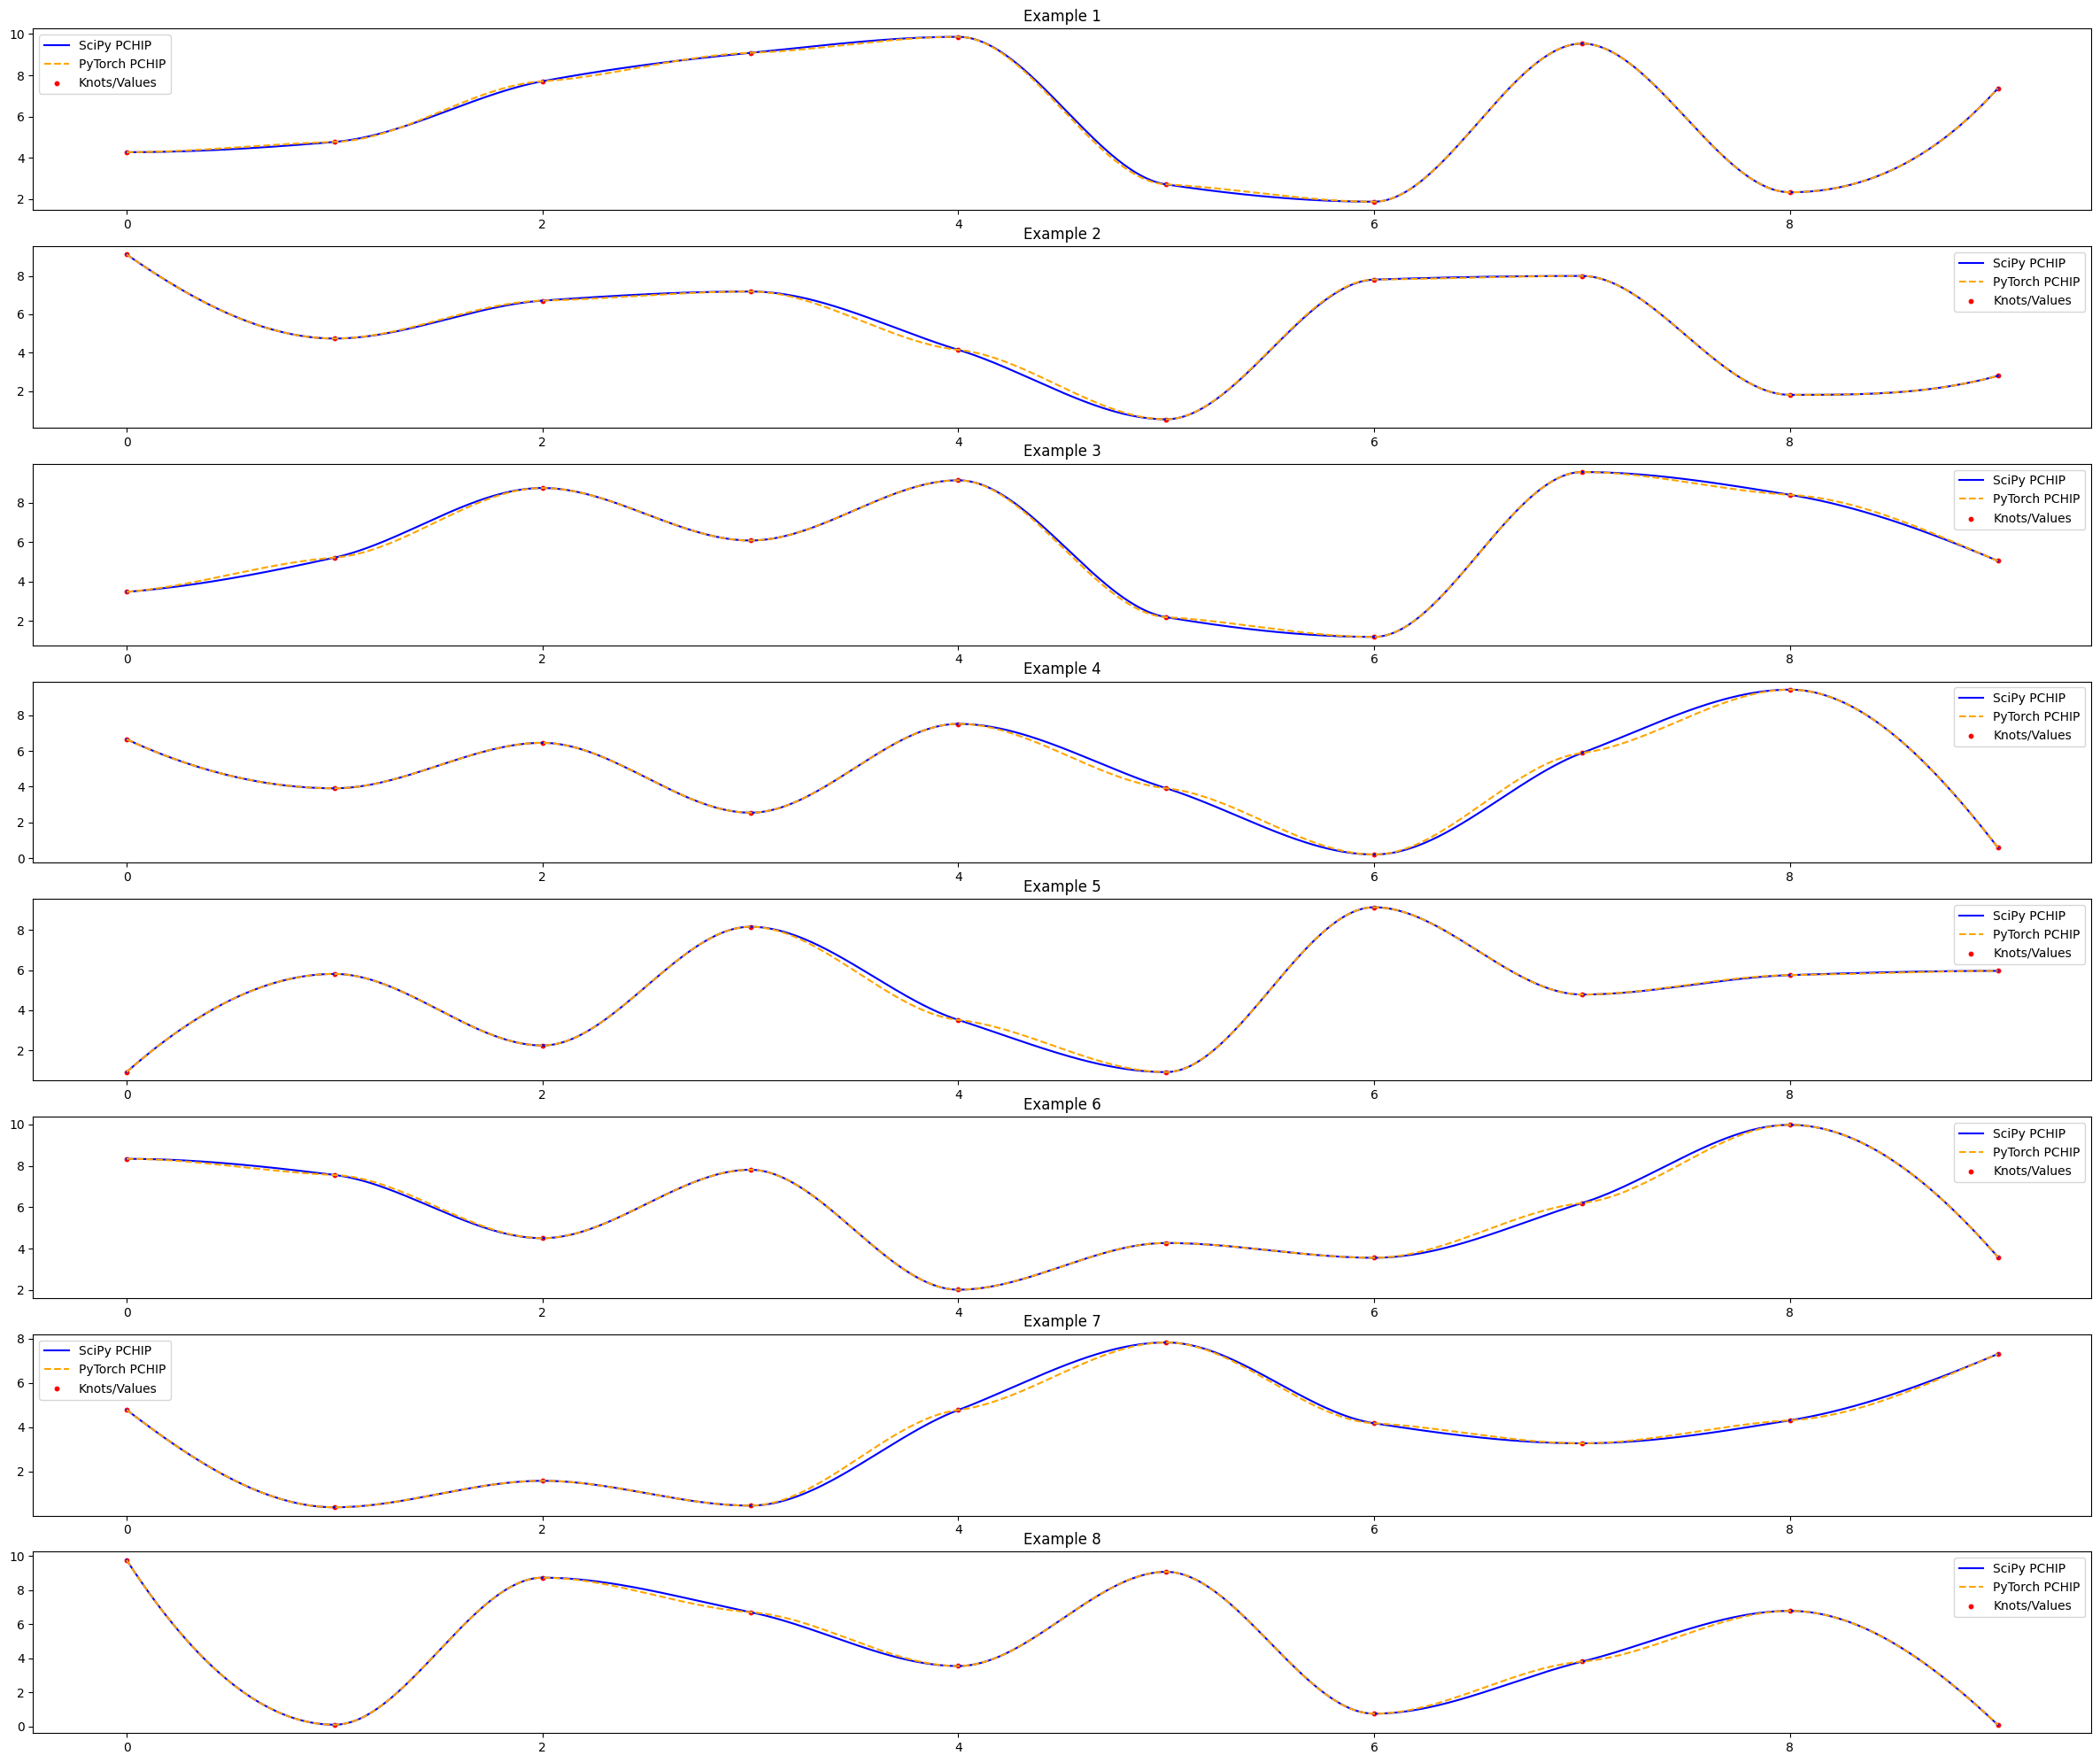

In [28]:
# Import libraries for testing
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator

# Designate device and dtype
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32

# Hyperparameters
B = 1000
N = 10
Nf = 1000

#Profile
Xs = np.linspace(0.0, 9, num=Nf)
Xt = torch.tensor(Xs, device=device, dtype=dtype)

#Generate knots & vals
knots = torch.tile(torch.linspace(0.0, 9, steps=N, device=device, dtype=dtype).unsqueeze(0), (B, 1))
noise = torch.randn((B, N), device=device, dtype=dtype)*0.0001
knots += noise
vals = torch.rand((B, N), device=device, dtype=dtype)*10.0

#Create interpolators, evaluate
t0_pt = time.perf_counter()
torch_interp = PytorchPchipInterpolator(knots, vals, extrapolate=True)
torch_profs = torch_interp(Xt)
dt_pt = time.perf_counter() - t0_pt
t0_sp = time.perf_counter()
scipy_interps = [PchipInterpolator(knots[i].cpu().numpy(), vals[i].cpu().numpy(), extrapolate=True) for i in range(B)]
scipy_profs = np.array([scipy_interps[i](Xs) for i in range(B)])
dt_sp = time.perf_counter() - t0_sp
torch_profs = torch_profs.cpu().numpy()

#Print timings
print(f"PyTorch PCHIP time for {B} profiles: {dt_pt:.6f} s")
print(f"SciPy PCHIP time for {B} profiles: {dt_sp:.6f} s")
print(f"Speedup: {dt_sp/dt_pt:.2f}x")

#Compute error
max_error = np.max(np.abs(torch_profs - scipy_profs))
avg_error = np.mean(np.abs(torch_profs - scipy_profs))
print(f"\nAvg error between PyTorch and SciPy PCHIP: {avg_error:.6e}")
print(f"Max error between PyTorch and SciPy PCHIP: {max_error:.6e}")

# Plot 8 examples
fig, axs = plt.subplots(8, 1, figsize=(30, 25))

for i in range(8):
	ax = axs[i]
	ax.plot(Xs, scipy_profs[i], label='SciPy PCHIP', color='blue')
	ax.plot(Xs, torch_profs[i], '--', label='PyTorch PCHIP', color='orange')
	ax.scatter(knots[i].cpu().numpy(), vals[i].cpu().numpy(), color='red', label='Knots/Values', s=10)
	ax.set_title(f'Example {i+1}')
	ax.legend()